## VAR vs VARMAX Model CV New Features


In this notebook, we will validate which model performs better given computational constraints: a VAR model retrained after each prediction or a VARMAX retrained every 20 predictions. To do so, we will retrun the model and functions constructed in [Systems_Identification_Fitting](Systems_Identification_Fitting.ipynb).

In [1]:
# import libraries
import pandas as pd
import numpy as np
from scipy import stats
import math as m
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, VARMAX
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import warnings
import os
import time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore")

%matplotlib inline 

os.chdir('..')

states = pd.read_csv('data/states.1200.csv')
del states['Unnamed: 0']
states.head()

,marketPriceEth,marketPriceUsd,block_number,debtAvailableToSettle,globalDebt,globalDebtCeiling,systemSurplus,totalActiveSafeCount,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,RaiDrawnFromSAFEs,collateral,debt,EthInUniswap,RaiInUniswap,ETH Price (OSM),block_timestamp
0,0.001476,3.115038,12163538,13643.859362,3.694647e+07,115792089237316195423570985008687.9,184447.332614,980,0.844051,0.999981,0.999845,3.033131,3.669856e+07,6921.6132,1.398615e+06,47370.263641,3.211457e+07,2130.090000,2021-04-03 01:10:15+00:00
1,0.001476,3.115038,12163808,13643.859362,3.694647e+07,115792089237316195423570985008687.9,184447.332614,980,0.844051,0.999981,0.999845,3.033072,3.669856e+07,6921.6132,1.398615e+06,47388.171967,3.210247e+07,2132.768622,2021-04-03 02:10:11+00:00
2,0.001476,3.115038,12164098,13643.859362,3.694647e+07,115792089237316195423570985008687.9,184447.332614,980,0.784730,0.999972,0.999779,3.032997,3.669856e+07,6913.6132,1.398615e+06,47387.538619,3.210178e+07,2115.468053,2021-04-03 03:10:28+00:00
3,0.001469,3.083544,12164400,13643.859362,3.701089e+07,115792089237316195423570985008687.9,184586.897248,980,0.784730,0.999972,0.999779,3.032912,3.676330e+07,6913.6132,1.398615e+06,47475.841207,3.217051e+07,2100.335393,2021-04-03 04:11:05+00:00
4,0.001463,3.094035,12164647,13643.859362,3.705626e+07,115792089237316195423570985008687.9,184629.005401,979,0.784730,0.999972,0.999779,3.032830,3.680853e+07,6911.2132,1.397797e+06,47245.283268,3.228967e+07,2093.917874,2021-04-03 05:09:44+00:00


In [2]:
# add additional state variables
states['RedemptionPriceinEth'] = states['RedemptionPrice'] / states['ETH Price (OSM)']
states['RedemptionPriceError'] = states['RedemptionPrice'] - states['marketPriceUsd']

In [3]:
# define constants (will come from cadCAD model but added here for calculations)
params = {
    'liquidation_ratio': 1.45,
    'debt_ceiling': 1e9,
    'uniswap_fee': 0.003,
    'arbitrageur_considers_liquidation_ratio': True,
}

<!-- ## Create Arbtrageur data vector $u^*$ -->

In [4]:
# subset state variables for arbitrageur vector
state_subset = states[['collateral','RaiDrawnFromSAFEs','RaiInUniswap','EthInUniswap']]

# map state data to vector fields 
state_subset.columns = ['Q','D','Rrai','Reth']

# alpha is the smoothing factor
local = state_subset.ewm(alpha=0.8).mean()
local

,Q,D,Rrai,Reth
0,6921.613200,3.669856e+07,3.211457e+07,47370.263641
1,6921.613200,3.669856e+07,3.210448e+07,47385.187246
2,6915.161587,3.669856e+07,3.210230e+07,47387.083515
3,6913.920892,3.675043e+07,3.215696e+07,47458.203461
4,6911.754045,3.679692e+07,3.226316e+07,47287.812781
...,...,...,...,...
1195,1083.900534,1.084647e+07,6.003190e+06,6575.363667
1196,1083.900470,1.084753e+07,6.038279e+06,6537.221037
1197,1083.900457,1.084646e+07,6.039119e+06,6559.444915
1198,1083.900455,1.085313e+07,6.093610e+06,6508.444876


In [5]:
# function to create coordinate transformations
def coordinate_transformations(params,df,Q,R_eth,R_rai,D,RedemptionPrice,EthPrice):
    '''
    Description:
    Function that takes in pandas dataframe and the names of columns
    
    Parameters:
    df: pandas dataframe containing states information
    Q: dataframe column name
    R_eth: dataframe column name
    R_rai: dataframe column name
    D: dataframe column name
    RedemptionPrice: dataframe column name
    EthPrice: dataframe column name

    Returns: Pandas dataframe with alpha, beta, gamma, delta transformed values
    
    Example:
    
    coordinate_transformations(params,states,'collateral','EthInUniswap','RaiInUniswap',
                           'RaiDrawnFromSAFEs','RedemptionPrice','ETH Price (OSM)')[['alpha','beta','gamma','delta']]
    
    Reference https://hackmd.io/w-vfdZIMTDKwdEupeS3qxQ
    
    '''
    
    # Calculate alpha, the change in debt relative to debt ceiling
    d = df[D].diff()
    d.fillna(0,inplace=True)
    df['d'] = d
    

    df['alpha'] = df['d'] / params['debt_ceiling']

    # calculate beta
    # how "allowed" the collateral lock, debt drawn activity is
    # reference
    df['C_o'] = (df[RedemptionPrice]/states[EthPrice]) * params['liquidation_ratio']

    q = df[Q].diff()
    q.fillna(0,inplace=True)
    df['q'] = q


    df['C_1'] = (df['C_o'] * df[D]) - df[Q]

    df['beta'] = (df['q'] - (df['C_o']*df['d']))/ df['C_1']

    # calculate gamma, the relative change in RAI reserve
    r = df[R_rai].diff()
    r.fillna(0,inplace=True)
    df['r'] = r


    df['gamma'] = df['r']/df[R_rai]

    # calculate delta, the relative change in ETH reserve
    z = df[R_eth].diff()
    z.fillna(0,inplace=True)
    df['z'] = z


    df['delta'] = df['z']/df[R_eth]
    
    df['eth'] = states['ETH Price (OSM)']
    df['rp'] = states['RedemptionPrice']
    df['rp_error'] = states['RedemptionPriceError']
    df['rp_eth'] = states['RedemptionPriceinEth']
    
    return df

In [6]:
transformed = coordinate_transformations(params,states,'collateral','EthInUniswap','RaiInUniswap',
                           'RaiDrawnFromSAFEs','RedemptionPrice','ETH Price (OSM)')[['alpha','beta','gamma','delta', 'eth','rp','rp_error', 'rp_eth']]

transformed



,alpha,beta,gamma,delta,eth,rp,rp_error,rp_eth
0,0.000000,0.000000,0.000000,0.000000,2130.090000,3.033131,-0.081907,0.001424
1,0.000000,0.000000,-0.000377,0.000378,2132.768622,3.033072,-0.081966,0.001422
2,0.000000,-0.000115,-0.000022,-0.000013,2115.468053,3.032997,-0.082041,0.001434
3,0.000065,-0.001935,0.002137,0.001860,2100.335393,3.032912,-0.050633,0.001444
4,0.000045,-0.001384,0.003690,-0.004880,2093.917874,3.032830,-0.061205,0.001448
...,...,...,...,...,...,...,...,...
1195,0.000004,-0.000359,0.009173,-0.009223,2702.280000,3.007422,-0.009891,0.001113
1196,0.000000,0.000000,0.005464,-0.005587,2757.389589,3.007430,-0.003379,0.001091
1197,-0.000002,0.000158,-0.001279,0.005684,2773.590000,3.007431,-0.005950,0.001084
1198,0.000009,-0.000846,0.011119,-0.010670,2761.044990,3.007393,0.012835,0.001089


In [7]:
# add additional signals to arbitrageur state
local['RedemptionPrice'] = states['RedemptionPrice']
local['ETH Price (OSM)'] = states['ETH Price (OSM)']

local

,Q,D,Rrai,Reth,RedemptionPrice,ETH Price (OSM)
0,6921.613200,3.669856e+07,3.211457e+07,47370.263641,3.033131,2130.090000
1,6921.613200,3.669856e+07,3.210448e+07,47385.187246,3.033072,2132.768622
2,6915.161587,3.669856e+07,3.210230e+07,47387.083515,3.032997,2115.468053
3,6913.920892,3.675043e+07,3.215696e+07,47458.203461,3.032912,2100.335393
4,6911.754045,3.679692e+07,3.226316e+07,47287.812781,3.032830,2093.917874
...,...,...,...,...,...,...
1195,1083.900534,1.084647e+07,6.003190e+06,6575.363667,3.007422,2702.280000
1196,1083.900470,1.084753e+07,6.038279e+06,6537.221037,3.007430,2757.389589
1197,1083.900457,1.084646e+07,6.039119e+06,6559.444915,3.007431,2773.590000
1198,1083.900455,1.085313e+07,6.093610e+06,6508.444876,3.007393,2761.044990


In [8]:
transformed_arbitrageur = coordinate_transformations(params,local,'Q','Reth','Rrai',
                           'D','RedemptionPrice','ETH Price (OSM)')[['alpha','beta','gamma','delta']]

transformed_arbitrageur

,alpha,beta,gamma,delta
0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,-0.000314,0.000315
2,0.000000,-0.000093,-0.000068,0.000040
3,0.000052,-0.001569,0.001700,0.001499
4,0.000046,-0.001418,0.003292,-0.003603
...,...,...,...,...
1195,0.000005,-0.000522,0.007211,-0.006817
1196,0.000001,-0.000105,0.005811,-0.005835
1197,-0.000001,0.000105,0.000139,0.003388
1198,0.000007,-0.000656,0.008942,-0.007836


In [9]:
def create_transformed_diffs(transformed_states):
    '''
    Description:
    Function for taking two pandas dataframes of transformed states and taking the difference
    to produce an error dataframe. 
    
    Parameters:
    transformed_states: pandas dataframe with alpha, beta, gamma, and delta features
    transformed_arbitrageur: pandas dataframe with alpha, beta, gamma, and delta features

    Returns:
    error pandas dataframe and transformation object
    
    '''
    
    alpha_diff = transformed_states['alpha'].diff()# - transformed_arbitrageur['alpha']
    beta_diff = transformed_states['beta'].diff()# - transformed_arbitrageur['beta']
    gamma_diff = transformed_states['gamma'].diff()# - transformed_arbitrageur['gamma']
    delta_diff = transformed_states['delta'].diff()# - transformed_arbitrageur['delta']
    
    eth_diff = transformed_states['eth'].diff()
    rp_diff = transformed_states['rp'].diff()
    rp_error_diff = transformed_states['rp_error'].diff()
    rp_eth_diff = transformed_states['rp_eth'].diff()
    
    '''
    alpha_diff = transformed_states['alpha']
    beta_diff = transformed_states['beta']
    gamma_diff = transformed_states['gamma']
    delta_diff = transformed_states['delta']
    
    eth_diff = transformed_states['eth']
    rp_diff = transformed_states['rp']
    rp_error_diff = transformed_states['rp_error']
    rp_eth_diff = transformed_states['rp_eth']
    '''

    e_u = pd.DataFrame(alpha_diff)
    e_u['beta'] = beta_diff
    e_u['gamma'] = gamma_diff
    e_u['delta'] = delta_diff
    
    e_u['eth'] = eth_diff
    e_u['rp'] = rp_diff
    e_u['rp_error'] = rp_error_diff
    #e_u['rp_eth'] = rp_eth_diff
    

    e_u = e_u.astype(float)
    
    return e_u

e_u = create_transformed_diffs(transformed)
e_u.head()

,alpha,beta,gamma,delta,eth,rp,rp_error,rp_eth
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.000000,-0.000377,0.000378,2.678622,-0.000059,-0.000059,-0.000002
2,0.000000,-0.000115,0.000355,-0.000391,-17.300569,-0.000076,-0.000076,0.000012
3,0.000065,-0.001819,0.002158,0.001873,-15.132660,-0.000085,0.031409,0.000010
4,-0.000020,0.000551,0.001554,-0.006740,-6.417519,-0.000082,-0.010573,0.000004


In [10]:
def power_transformation(e_u):
    '''
    Definition:
    Function to perform a power transformation on the coordinate 
    transformed differenced data
    
    Parameters:
    e_u: Dataframe of coordinated transformed differenced data
    
    Required:
    import pandas as pd
    from sklearn.preprocessing import PowerTransformer
    
    Returns:
    Transformed dataframe and transformation object
    
    Example:
    transformed_df, pt = power_transformation(e_u)
    '''
    pt = PowerTransformer()
    yeo= pd.DataFrame(pt.fit_transform(e_u),columns=e_u.columns)

    return yeo, pt

In [11]:
def VARMAX_prediction(e_u, RedemptionPriceError, newRedemptionPriceError, steps=1, lag=1):
    '''
    Description:
    Function to train and forecast a VARMAX model one step into the future
    
    Parameters:
    e_u: errors pandas dataframe
    RedemptionPriceErrorPrevious: 1d Numpy array of RedemptionPriceError values
    newRedemptionPriceError: exogenous latest redemption price error signal - float
    steps: Number of forecast steps. Default is 1
    lag: number of autoregressive lags. Default is 1
    
    Returns:
    Numpy array of transformed state changes
    
    Example
    Y_pred = VARMAX_prediction(train,states_train['RedemptionPriceError'],
                  states_test['RedemptionPriceError'][0:5],steps=5,lag=1)
    '''
    # instantiate the VARMAX model object from statsmodels 
    model = VARMAX(endog=e_u.values, exog=RedemptionPriceError,
                   initialization='approximate_diffuse', measurement_error=True)

    # fit model with determined lag values
    results = model.fit(order=(lag, 0), verbose=False, disp=0)
    
    Y_pred = results.forecast(steps=steps, exog=newRedemptionPriceError)
    
    return Y_pred.values

In [12]:
def VAR_prediction(e_u,lag=1):
    '''
    Description:
    Function to train and forecast a VAR model one step into the future
    
    Parameters:
    e_u: errors pandas dataframe
    lag: number of autoregressive lags. Default is 1
    
    Returns:
    Numpy array of transformed state changes
    
    Example
    VAR_prediction(e_u,6)    
    '''
    # instantiate the VAR model object from statsmodels 
    model = VAR(e_u)

    # fit model with determined lag values
    results = model.fit(lag, verbose=False)
    
    lag_order = results.k_ar
    
    Y_pred = results.forecast(e_u.values[-lag_order:],1)


    return Y_pred[0]

In [13]:
def rf_prediction(e_u, lag=1, n_features=4):
    
    X = []
    y = []    
    dfs = [e_u]
    for i in range(lag):
        dfs.append(e_u.shift(i+1))
        
    shifted_df = pd.concat(dfs, axis=1)

    for i, row in shifted_df.iloc[lag:].iterrows():
        y.append(row[:n_features])
        X.append(row[n_features:]) # shape = (,n_features * lag)
    
    X = np.array(X)
    y = np.array(y)
    
    rf = RandomForestRegressor(100)
    
    rf.fit(X, y)
    
    final_x = shifted_df.iloc[-1,:lag*n_features].values.reshape(1,-1)
    pred = rf.predict(final_x)
    
    return pred[0]
    
    

In [14]:
def invert_power_transformation(pt,prediction):
    '''
    Definition:
    Function to invert power transformation
    
    Parameters:
    pt: transformation object
    prediction: Numpy array of model state coordinate transformed percentage changes
    
    Required:
    import pandas as pd
    from sklearn.preprocessing import PowerTransformer
    
    Returns:
    inverted transformation numpy array
    
    Example:
    inverted_array = invert_power_transformation(pt,prediction)
    
    '''
    # transform back into coordinate system
    inverted = pt.inverse_transform(prediction)
    
    return inverted

In [15]:
e_u_yeo, pt = power_transformation(e_u)

In [21]:
e_u_yeo = e_u_yeo.iloc[1:]

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'delta'}>,
        <AxesSubplot:title={'center':'eth'}>,
        <AxesSubplot:title={'center':'rp'}>],
       [<AxesSubplot:title={'center':'rp_error'}>,
        <AxesSubplot:title={'center':'rp_eth'}>, <AxesSubplot:>]],
      dtype=object)

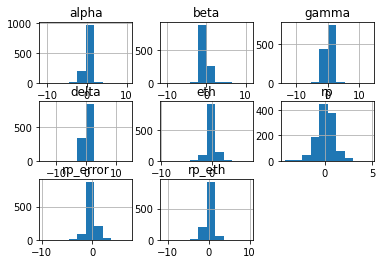

In [22]:
e_u_yeo.hist()

In [ ]:
for lag_size in range(1, 20):
    rf_scores = []
    var_scores = []
    varmax_scores = []
    baseline_scores = []
    
    s = time.time()
    tscv = TimeSeriesSplit(10)
    #for train_index, test_index in tscv.split(e_u_yeo):
    for train_index, test_index in list(tscv.split(e_u_yeo))[-3:]:
       
        train_orig = e_u_yeo.iloc[train_index]
        test_orig = e_u_yeo.iloc[test_index]
        pt = PowerTransformer()
        train = pd.DataFrame(pt.fit_transform(train_orig), columns=train_orig.columns)
        test = pd.DataFrame(pt.transform(test_orig), columns=test_orig.columns)

        test_len = 30
        
        states_train = states.iloc[train_index]
        states_test = states.iloc[test_index]
        
        rf_predictions = []
        train_var = train.copy()
        for i in range(0, test_len): 
            p = rf_prediction(train_var, lag=lag_size, n_features=8)
            rf_predictions.append(p)            
            train_var = train_var.append(test.iloc[i])
        
        
        varmax_predictions = []
        """
        train_var = train.copy()
        states_train_var = states_train.copy()
        for i in range(0, test_len): 
            p = VARMAX_prediction(train_var, states_train_var['RedemptionPriceError'],
                      states_test['RedemptionPriceError'].values[i], steps=1, lag=lag_size)
            varmax_predictions.append(p[0,:])
            train_var = train_var.append(test.iloc[i])
            states_train_var = states_train_var.append(states_test.iloc[i])
         """
            
        var_predictions = []
        train_var = train.copy()
        for i in range(0, test_len): 
            var_predictions.append(VAR_prediction(train_var, lag_size))
            train_var = train_var.append(test.iloc[i])
                                                                     
        rf_pred = np.array(rf_predictions)       
        var_pred = np.array(var_predictions)
        varmax_pred = np.array(varmax_predictions)
        
        rf_rmse = mean_squared_error(rf_pred, test[:test_len])
        var_rmse = mean_squared_error(var_pred, test[:test_len])
        #vmax_rmse = mean_squared_error(varmax_pred, test[:test_len])
        
        baseline = np.mean(train.values, axis=0).reshape(1, -1).repeat(test_len, axis=0)
        baseline_rmse = mean_squared_error(baseline, test[:test_len])
     
        rf_scores.append(rf_rmse)
        var_scores.append(var_rmse)
        #varmax_scores.append(vmax_rmse)
        baseline_scores.append(baseline_rmse)

    print(f"{lag_size=}, mean/std var score={np.mean(var_scores):.3f}/{np.std(var_scores):.3f}; "
          f"mean/std varmax score={np.mean(varmax_scores):.3f}/{np.std(varmax_scores):.3f}; "
          f"mean/std rf score={np.mean(rf_scores):.3f}/{np.std(rf_scores):.3f}; "
          f"mean/std baseline score:{np.mean(baseline_scores):.3f}/{np.std(baseline_scores):.3f} "
          f"time: {(time.time() - s):.1f}")


lag_size=1, mean/std var score=2.892/2.550; mean/std varmax score=nan/nan; mean/std rf score=2.905/1.735; mean/std baseline score:3.990/2.618 time: 68.8
lag_size=2, mean/std var score=2.553/2.305; mean/std varmax score=nan/nan; mean/std rf score=2.892/1.898; mean/std baseline score:3.990/2.618 time: 110.7
lag_size=3, mean/std var score=2.369/2.141; mean/std varmax score=nan/nan; mean/std rf score=2.988/1.902; mean/std baseline score:3.990/2.618 time: 158.0
lag_size=4, mean/std var score=2.288/2.044; mean/std varmax score=nan/nan; mean/std rf score=2.768/1.653; mean/std baseline score:3.990/2.618 time: 203.7
lag_size=5, mean/std var score=2.213/1.917; mean/std varmax score=nan/nan; mean/std rf score=2.834/1.719; mean/std baseline score:3.990/2.618 time: 248.7
lag_size=6, mean/std var score=2.213/1.939; mean/std varmax score=nan/nan; mean/std rf score=2.717/1.530; mean/std baseline score:3.990/2.618 time: 298.6
lag_size=7, mean/std var score=2.249/1.990; mean/std varmax score=nan/nan; me

In [ ]:
# invert the power transformation
var_predictions = invert_power_transformation(pt,var_predictions)
varmax_predictions = invert_power_transformation(pt,varmax_predictions)

## Model Evaluation Comparision (in coordinate transformed and power transformed differenced space)  

In [ ]:
var_predictions_df = pd.DataFrame(var_predictions,columns=['alpha','beta','gamma','delta'])
varmax_predictions_df = pd.DataFrame(varmax_predictions,columns=['alpha','beta','gamma','delta'])

In [ ]:
var_alpha_rmse = m.sqrt(mean_squared_error(var_predictions_df['alpha'], test.head(20)['alpha']))
varmax_alpha_rmse = m.sqrt(mean_squared_error(varmax_predictions_df['alpha'], test.head(20)['alpha']))
var_beta_rmse = m.sqrt(mean_squared_error(var_predictions_df['beta'], test.head(20)['beta']))
varmax_beta_rmse = m.sqrt(mean_squared_error(varmax_predictions_df['beta'], test.head(20)['beta']))
var_gamma_rmse = m.sqrt(mean_squared_error(var_predictions_df['gamma'], test.head(20)['gamma']))
varmax_gamma_rmse = m.sqrt(mean_squared_error(varmax_predictions_df['gamma'], test.head(20)['gamma']))
var_delta_rmse = m.sqrt(mean_squared_error(var_predictions_df['delta'], test.head(20)['delta']))
varmax_delta_rmse = m.sqrt(mean_squared_error(varmax_predictions_df['delta'], test.head(20)['delta']))

## Alpha - Root Mean Square Error

In [ ]:

if var_alpha_rmse >= varmax_alpha_rmse:
    print('VARMAX performs better by {}'.format(varmax_alpha_rmse-var_alpha_rmse))
else:
    print('VAR performs better by {}'.format(var_alpha_rmse-varmax_alpha_rmse))

## Beta - Root Mean Square Error

In [ ]:

if var_beta_rmse >= varmax_beta_rmse:
    print('VARMAX performs better by {}'.format(varmax_beta_rmse-var_beta_rmse))
else:
    print('VAR performs better by {}'.format(var_beta_rmse-varmax_beta_rmse))

## Gamma - Root Mean Square Error

In [ ]:

if var_gamma_rmse >= varmax_gamma_rmse:
    print('VARMAX performs better by {}'.format(varmax_gamma_rmse-var_gamma_rmse))
else:
    print('VAR performs better by {}'.format(var_gamma_rmse-varmax_gamma_rmse))

## Delta - Root Mean Square Error

In [ ]:

if var_delta_rmse >= varmax_delta_rmse:
    print('VARMAX performs better by {}'.format(varmax_delta_rmse-var_delta_rmse))
else:
    print('VAR performs better by {}'.format(var_delta_rmse-varmax_delta_rmse))

In [ ]:
print('Aggregated VARMAX RMSE in absolute values:')
print(abs(varmax_alpha_rmse) + abs(varmax_beta_rmse) + abs(varmax_gamma_rmse) + abs(varmax_delta_rmse))

print('Aggregated VAR RMSE in absolute values:')
print(abs(var_alpha_rmse) + abs(var_beta_rmse) + abs(var_gamma_rmse) + abs(var_delta_rmse))

## Model Evaluation Comparision as States

In [ ]:
def inverse_transformation_and_state_update(Y_pred,previous_state,params):
    '''
    Description:
    Function to take system identification model prediction and invert transfrom and create new state
    
    Parameters:
    y_pred: numpy array of transformed state changes
    previous_state: pandas dataframe of previous state or 'current' state
    params: dictionary of system parameters
    
    Returns:
    pandas dataframe of new states 
    
    Example:
    inverse_transformation_and_state_update(Y_pred,previous_state,params)
    '''
    
    d_star = Y_pred[0] * params['debt_ceiling']
    
    q_star = previous_state['C_o'] * params['debt_ceiling'] * Y_pred[0] + previous_state['C_1'] * Y_pred[1]
    
    r_star = Y_pred[2] * previous_state['gamma'] * previous_state['RaiInUniswap']

    z_star = Y_pred[3] * previous_state['delta'] * previous_state['EthInUniswap']

    new_state = pd.DataFrame(previous_state[['collateral','EthInUniswap','RaiInUniswap','RaiDrawnFromSAFEs']].to_dict())
    new_state['Q'] = new_state['collateral'] + q_star
    new_state['D'] = new_state['RaiDrawnFromSAFEs'] + d_star
    new_state['R_Rai'] = new_state['RaiInUniswap'] + r_star
    new_state['R_Eth'] = new_state['EthInUniswap'] + z_star
    
    return new_state[['Q','D','R_Rai','R_Eth']]



In [ ]:
VAR_new_states = []
index = -21
for i in range(0,20): 
    previous_state = states.iloc[train_var.index[index:index+1]]
    VAR_new_states.append(inverse_transformation_and_state_update(var_predictions[i],previous_state,params))
    index += 1
    
VAR_new_states = pd.concat(VAR_new_states)
VAR_new_states

In [ ]:
VARMAX_new_states = []
index = -21
for i in range(0,20): 
    previous_state = states.iloc[train_var.index[index:index+1]]
    VARMAX_new_states.append(inverse_transformation_and_state_update(varmax_predictions[i],previous_state,params))
    index += 1
    
VARMAX_new_states = pd.concat(VARMAX_new_states)
VARMAX_new_states

In [ ]:
test_data = states.iloc[test.index[0:20]][['collateral','EthInUniswap','RaiInUniswap','RaiDrawnFromSAFEs']]


In [ ]:
test_data

## Q - Root Mean Square Error

In [ ]:
var_q_rmse = m.sqrt(mean_squared_error(VAR_new_states['Q'], test_data['collateral']))
varmax_q_rmse = m.sqrt(mean_squared_error(VARMAX_new_states['Q'], test_data['collateral']))
if var_q_rmse >= varmax_q_rmse:
    print('VARMAX performs better by {}'.format(varmax_q_rmse-var_q_rmse))
else:
    print('VAR performs better by {}'.format(var_q_rmse-varmax_q_rmse))

## D - Root Mean Square Error

In [ ]:
var_d_rmse = m.sqrt(mean_squared_error(VAR_new_states['D'], test_data['RaiDrawnFromSAFEs']))
varmax_d_rmse = m.sqrt(mean_squared_error(VARMAX_new_states['D'], test_data['RaiDrawnFromSAFEs']))
if var_d_rmse >= varmax_d_rmse:
    print('VARMAX performs better by {}'.format(varmax_d_rmse-var_d_rmse))
else:
    print('VAR performs better by {}'.format(var_d_rmse-varmax_d_rmse))

## R_Rai - Root Mean Square Error

In [ ]:
var_rai_rmse = m.sqrt(mean_squared_error(VAR_new_states['R_Rai'], test_data['RaiInUniswap']))
varmax_rai_rmse = m.sqrt(mean_squared_error(VARMAX_new_states['R_Rai'], test_data['RaiInUniswap']))
if var_rai_rmse >= varmax_rai_rmse:
    print('VARMAX performs better by {}'.format(varmax_rai_rmse-var_rai_rmse))
else:
    print('VAR performs better by {}'.format(var_rai_rmse-varmax_rai_rmse))

## R_Eth - Root Mean Square Error

In [ ]:
var_eth_rmse = m.sqrt(mean_squared_error(VAR_new_states['R_Eth'], test_data['EthInUniswap']))
varmax_eth_rmse = m.sqrt(mean_squared_error(VARMAX_new_states['R_Eth'], test_data['EthInUniswap']))
if var_eth_rmse >= varmax_eth_rmse:
    print('VARMAX performs better by {}'.format(varmax_eth_rmse-var_eth_rmse))
else:
    print('VAR performs better by {}'.format(var_eth_rmse-varmax_eth_rmse))

In [ ]:
print('Aggregated VARMAX RMSE in absolute values:')
print(abs(varmax_eth_rmse) + abs(varmax_rai_rmse) + abs(varmax_d_rmse) + abs(varmax_q_rmse))

print('Aggregated VAR RMSE in absolute values:')
print(abs(var_eth_rmse) + abs(var_rai_rmse) + abs(var_d_rmse) + abs(var_q_rmse))

### Exponential weighted moving average test grid

#### Aggregated RMSE values with VARMAX(1) and VAR(6)
VAR lags changed between alphas but for simplicity we held constant

|Alpha   |VARMAX RMSE   | VAR RMSE  | 
|---|---|---|
|0.1   |346,906.48   |356,511.48   |
|0.2  |355,980.48   |353,095.32   |
|0.3  |352,226.20   |350,923.13   |
|0.4  |347,489.97   |348,758.57  |
|0.5  |348,488.02  |347,155.68   |
|0.6  |348,345.53   |346,199.91   |
|0.7  |347,916.76   |345,765.18   |
|**0.8**  |348,061.60   |**345,692.82**   |
|0.9  |349,104.38   |346,223   |

## Conclusion


In this notebook we evaluated the performance of a VARMAX(1) model trained every 20 timesteps an the exogenous signal of redemption price error, against a VAR(15) model retrained everytime step. We decided on using a VAR(15) for the Rai Digital Twin because it performs slightly better, being able to retrain at every prediction timestep. 